In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
num_x, num_y, num_z = 300, 300, 300
radius = 120

# Initialize IOR fields
center = (num_x//2, num_y//2, num_z//2)
x, y, z = torch.meshgrid(torch.arange(num_x), torch.arange(num_y), torch.arange(num_z), indexing='ij')
mask = ((x - center[0])**2 + (y - center[1])**2 + (z - center[2])**2 <= radius**2).to(device)

convex_lens_ior_field = torch.ones((num_x, num_y, num_z), dtype=torch.float16, device=device)
convex_lens_ior_field[mask] = 1.5


# Initialize the wavefront positions and directions
initial_wavefront_positions = torch.tensor([(0, y, z) for y in range(num_y) for z in range(num_z)], dtype=torch.float16, device=device)
initial_wavefront_directions = torch.tensor([(1, 0, 0) for _ in range(num_y * num_z)], dtype=torch.float16, device=device)

In [3]:
def show_original(ior_field):    
    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_box_aspect([1,1,1])
    ax.set_xlim(0, num_x)
    ax.set_ylim(0, num_y)
    ax.set_zlim(0, num_z)

    initial_pos_np = initial_wavefront_positions.cpu().numpy()
    initial_dir_np = initial_wavefront_directions.cpu().numpy()

    # Initial wavefront
    ax.quiver(initial_pos_np[:, 0], initial_pos_np[:, 1], initial_pos_np[:, 2], 
              initial_dir_np[:, 0], initial_dir_np[:, 1], initial_dir_np[:, 2],
              length=1, color='green', normalize=True, linewidths=0.7, arrow_length_ratio=0.4, alpha=0.3)
    
    # IOR field
    ior_field = ior_field.cpu().numpy()
    x_points, y_points, z_points = np.where(ior_field == 1.5)
    ax.scatter(x_points, y_points, z_points, color='blue', alpha=0.01)

    ax.set_title("3D Representation of a Sphere")
    ax.set_xlabel('X Axis')
    ax.set_ylabel('Y Axis')
    ax.set_zlabel('Z Axis')
    plt.show()

# show_original(convex_lens_ior_field)

In [4]:
def compute_3d_gradients_torch(IOR):
    grad_x, grad_y, grad_z = torch.gradient(IOR)
    return grad_x, grad_y, grad_z

convex_grad_xyz_torch = compute_3d_gradients_torch(convex_lens_ior_field)

grad_x = convex_grad_xyz_torch[0].cpu().numpy()
grad_y = convex_grad_xyz_torch[1].cpu().numpy()
grad_z = convex_grad_xyz_torch[2].cpu().numpy()

# plt.figure(figsize=(8, 3))
# plt.subplot(131)
# plt.imshow(grad_x[:, :, num_z // 2], cmap='gray')  # Z轴的切面
# plt.title('Gradient along x-axis')
# plt.xlabel('x-axis')
# plt.ylabel('y-axis')
# plt.subplot(132)
# plt.imshow(grad_y[num_y // 2, :, :], cmap='gray')  # Y轴的切面
# plt.title('Gradient along y-axis')
# plt.xlabel('x-axis')
# plt.ylabel('z-axis')
# plt.subplot(133)
# plt.imshow(grad_z[:, num_x // 2, :], cmap='gray')  # X轴的切面
# plt.title('Gradient along z-axis')
# plt.xlabel('y-axis')
# plt.ylabel('z-axis')
# plt.tight_layout()
# plt.show()

In [5]:
def update_wavefront(pos, dir, grad_xyz, IOR, delta_t):
    indices = pos.int()

    # Obtain the refractive index at the current position
    n = IOR[indices[:, 0].clamp(0, IOR.shape[0] - 1),
            indices[:, 1].clamp(0, IOR.shape[1] - 1),
            indices[:, 2].clamp(0, IOR.shape[2] - 1)]

    # Calculate the new position and direction of the wavefront
    new_pos = pos + delta_t * dir / (n**2).unsqueeze(1)

    # Create a mask to ensure that the wavefront stays within the boundaries of the IOR field
    mask = (new_pos[:, 0] >= 0) & (new_pos[:, 0] < IOR.shape[0]) & \
           (new_pos[:, 1] >= 0) & (new_pos[:, 1] < IOR.shape[1]) & \
           (new_pos[:, 2] >= 0) & (new_pos[:, 2] < IOR.shape[2])
    mask = mask.unsqueeze(1)  # Add a dimension to match the shape of new_pos

    # only update the positions that are within the IOR boundaries
    new_pos = torch.where(mask, new_pos, pos)
    new_dir = torch.where(mask, dir + delta_t * torch.stack([grad_xyz[0][indices[:, 0], indices[:, 1], indices[:, 2]],  grad_xyz[1][indices[:, 0], indices[:, 1], indices[:, 2]], grad_xyz[2][indices[:, 0], indices[:, 1], indices[:, 2]]], dim=1) / n.unsqueeze(1), dir)

    return new_pos, new_dir


def simulate_wavefront_propagation(cur_IOR, grad_xyz, initial_wavefront_pos, initial_wavefront_dir, num_steps=100, delta_t=1.0):
    wavefront_pos_list = [initial_wavefront_pos]
    wavefront_dir_list = [initial_wavefront_dir]
    for _ in range(num_steps):
        new_positions, new_directions = update_wavefront(wavefront_pos_list[-1], wavefront_dir_list[-1], grad_xyz, cur_IOR, delta_t)
        wavefront_pos_list.append(new_positions)
        wavefront_dir_list.append(new_directions)
    return wavefront_pos_list, wavefront_dir_list


test_num_steps = 200
test_delta_t = 1 * num_x / 100
wavefront_positions_list, wavefront_directions_list = simulate_wavefront_propagation(convex_lens_ior_field, convex_grad_xyz_torch, initial_wavefront_positions, initial_wavefront_directions, num_steps=test_num_steps, delta_t=test_delta_t)

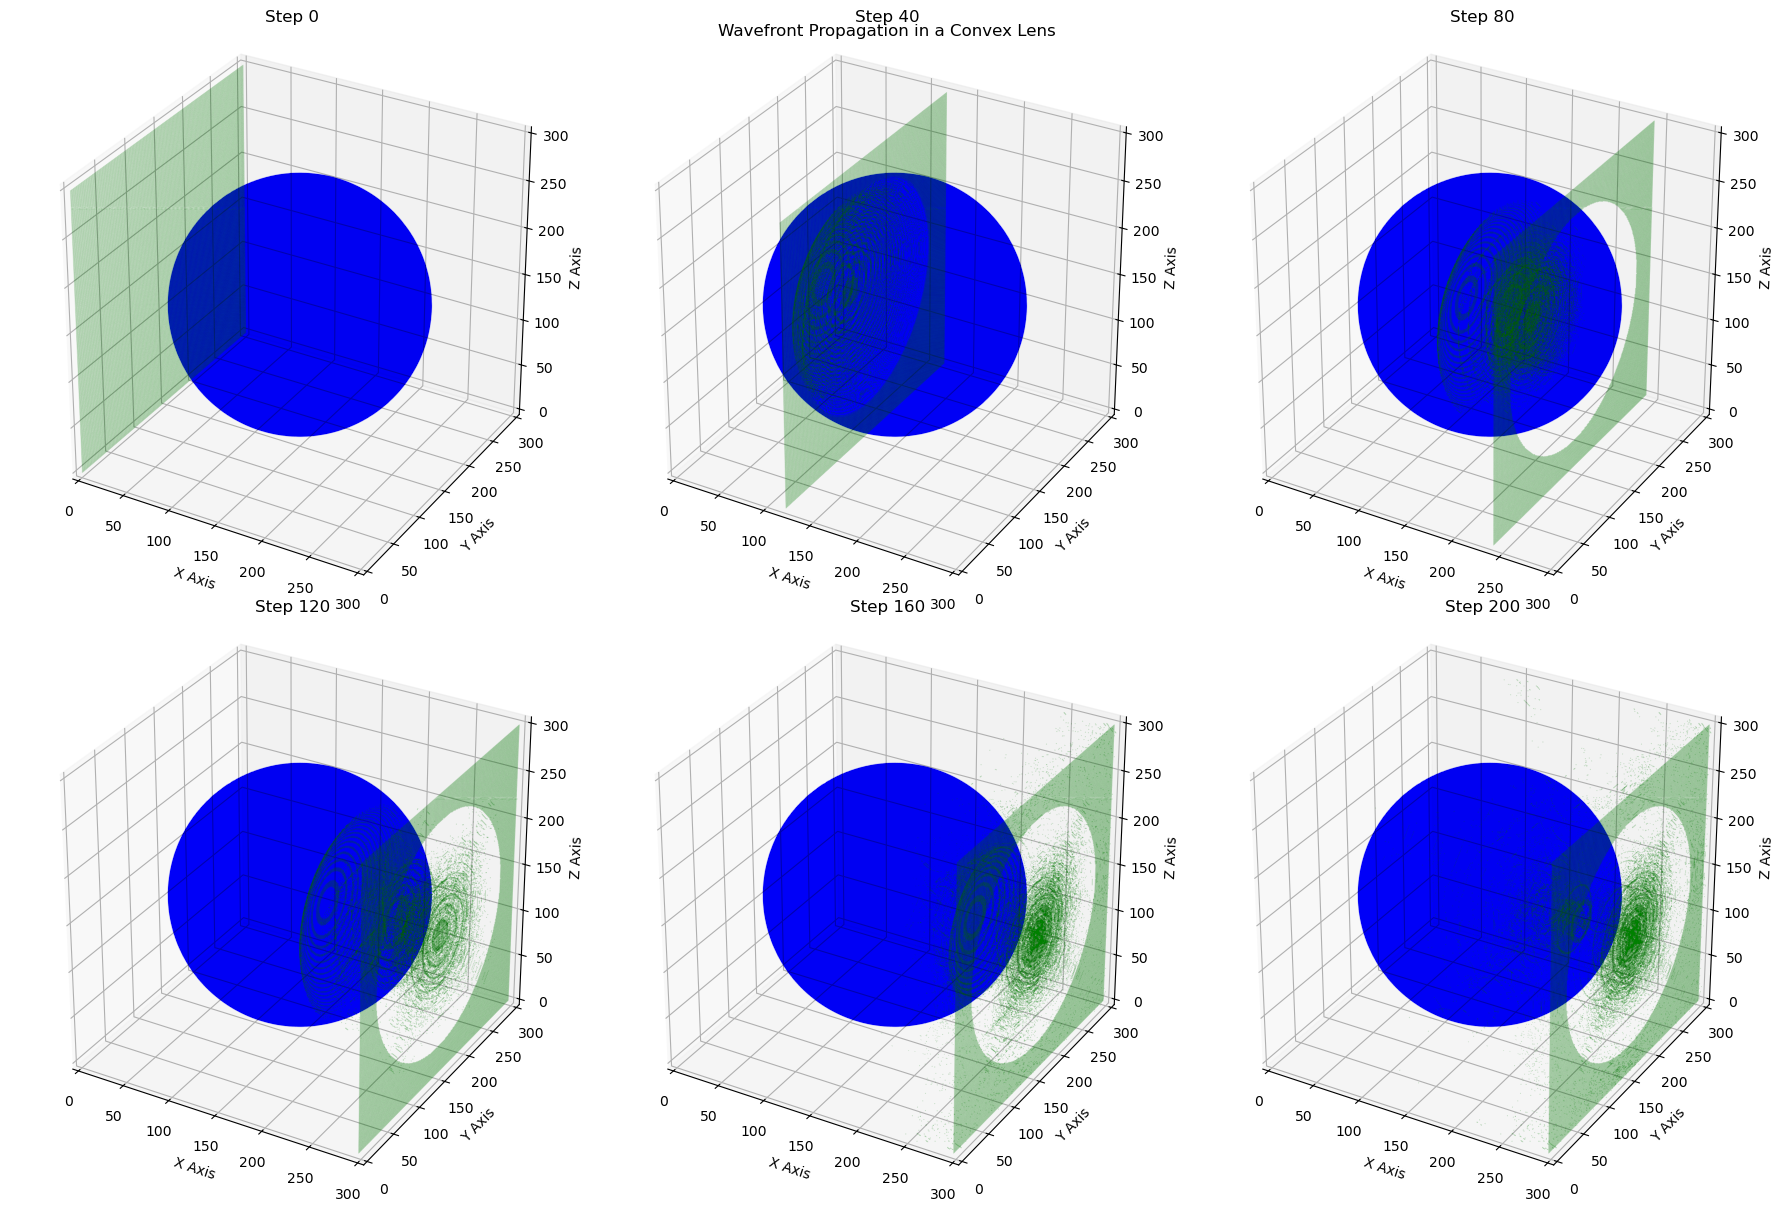

In [6]:
def show_propagation_results(convex_pos_res, convex_dir_res, IOR, num_show_images, fig_name):
    num_cols = min(num_show_images, 3)
    num_rows = (num_show_images + num_cols - 1) // num_cols
    num_steps = len(convex_pos_res) - 1

    show_indices = [i for i in range(0, num_steps+1, max(num_steps // (num_show_images-1), 1))]
    show_indices.append(num_steps)
    if len(show_indices) > num_show_images:
        show_indices = show_indices[:num_show_images]

    fig = plt.figure(figsize=(6 * num_cols, 6 * num_rows))
    
    for i, index in enumerate(show_indices):
        ax = fig.add_subplot(num_rows, num_cols, i + 1, projection='3d')
        ax.set_box_aspect([1,1,1])
        ax.set_xlim(0, IOR.shape[0])
        ax.set_ylim(0, IOR.shape[1])
        ax.set_zlim(0, IOR.shape[2])
        ax.set_xlabel('X Axis')
        ax.set_ylabel('Y Axis')
        ax.set_zlabel('Z Axis')
        ax.set_title(f"Step {index}")
        
        # 3D IOR field
        IOR_np = IOR.cpu().numpy() if IOR.is_cuda else IOR.numpy()
        x_points, y_points, z_points = np.where(IOR_np == 1.5)
        ax.scatter(x_points, y_points, z_points, color='blue', alpha=0.01)

        # Wavefront
        wavefront_positions = convex_pos_res[index].cpu().numpy() if convex_pos_res[index].is_cuda else convex_pos_res[index].numpy()
        wavefront_directions = convex_dir_res[index].cpu().numpy() if convex_dir_res[index].is_cuda else convex_dir_res[index].numpy()
        ax.quiver(wavefront_positions[:, 0], wavefront_positions[:, 1], wavefront_positions[:, 2], 
                  wavefront_directions[:, 0], wavefront_directions[:, 1], wavefront_directions[:, 2],
                  length=1, color='green', normalize=True, linewidths=0.7, arrow_length_ratio=0.4, alpha=0.1)
        
    fig.tight_layout()
    fig.suptitle(fig_name)
    plt.show()

num_show_images = 6
show_propagation_results(wavefront_positions_list, wavefront_directions_list, convex_lens_ior_field, num_show_images, "Wavefront Propagation in a Convex Lens")